In [26]:
from Model import Levels, ElectronsTransitionsData, AtomsTransitionsData, PickAndSolve, UFloat, utilities
import numpy as np
import pandas as pd
from Model.utilities import n_, s_
from tqdm.auto import tqdm
from PlotUtils.saveToCsv import saveToCsv, getNextFilename

from PlotUtils import errsPlot as plt, splt

splt.set_export_folder(".")

In [27]:
n_g = 2.687e25
T_g = 300

real_value = {
    'T_e' : 2,
    'f_e' : 10**-5
}

In [28]:
data = pd.read_csv('exports/SimulatedData.csv', index_col = False).to_dict('list')

data['density'] = [ UFloat.UFloat( n, s ) for n, s in zip( data['density_n'], data['density_s'] ) ]
data['label_idx'] = Levels.Levels().namesToIdxs( data['label'] )

In [29]:
# Loading data from a previous broad characterization
filename = 'results/r003'

prev = pd.read_csv( filename + '.csv', index_col = False )

f_es = np.unique( prev['f_es'].to_numpy() )
T_es = np.unique( prev['T_es'].to_numpy() )
chisquared = prev['chisquared'].to_numpy().reshape( ( len( f_es ), len( T_es ) ) )

In [30]:
# Spot the interesting area as above 85% of the chi squared
chisquared_f_e = np.min( chisquared, axis = 1 )
chisquared_T_e = np.min( chisquared, axis = 0 )

chisquared_f_e_idx = np.where( 1 / chisquared_f_e > 1 / np.min( chisquared_f_e ) * 0.75 )
chisquared_T_e_idx = np.where( 1 / chisquared_T_e > 1 / np.min( chisquared_T_e ) * 0.75 )

In [31]:
# Consequently, define the scanning range in the interesting area
f_es = np.linspace( f_es[ np.min( chisquared_f_e_idx ) - 1 ], f_es[ np.max( chisquared_f_e_idx ) + 1 ], 100 )
T_es = np.linspace( T_es[ np.min( chisquared_T_e_idx ) - 1 ], T_es[ np.max( chisquared_T_e_idx ) + 1 ], 100 )

In [ ]:
chisquared = np.zeros( ( len( f_es ), len( T_es ) ) )
real_value['chi2'] = 0
reps = 100


for k in tqdm( range( reps ), total = reps ):
    pas = PickAndSolve.PickAndSolve()
    for i, f_e in enumerate( f_es ):
        for j, T_e in enumerate( T_es ):
            chisquared[ i, j ] += pas.chiSquared_frompars( data['density'], data['label_idx'], n_g, f_e, T_e, T_g )
    real_value['chi2'] += pas.chiSquared_frompars( data['density'], data['label_idx'], n_g, real_value['f_e'], real_value['T_e'], T_g )


for i, f_e in enumerate( f_es ):
    for j, T_e in enumerate( T_es ):
        chisquared[ i, j ] = chisquared[ i, j ] / reps
real_value['chi2'] = real_value['chi2'] / reps

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
f_esm, T_esm = np.meshgrid( f_es, T_es )
filename = saveToCsv( { 'f_es': f_esm.flatten(), 'T_es': T_esm.flatten(), 'chisquared': chisquared.flatten() }, basename = filename + "_z" )

Saved as results/r003_z001


./results/r003_z001_chisquared_countourf.pdf


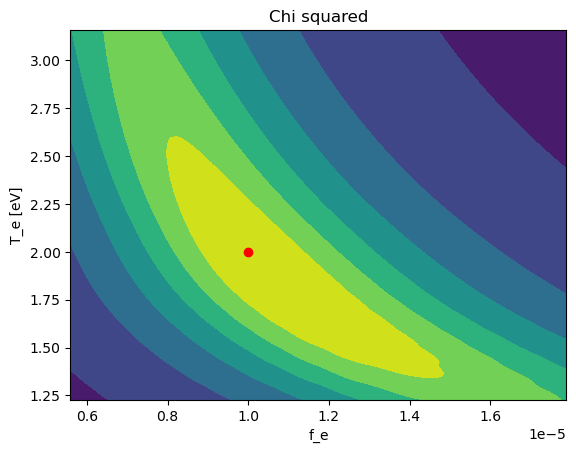

In [34]:
plt.contourf( f_es, T_es, 1 / chisquared.T )

plt.plot( real_value['f_e'], real_value['T_e'], 'ro' )

plt.xlabel("f_e")
plt.ylabel("T_e [eV]")

plt.title("Chi squared")

splt.export( filename + "_chisquared_countourf" )

In [35]:
chisquared_f_e = np.min( chisquared, axis = 1 )
chisquared_T_e = np.min( chisquared, axis = 0 )

result = {
    'f_e': f_es[ np.argmin( chisquared_f_e ) ],
    'T_e': T_es[ np.argmin( chisquared_T_e ) ],
    'chi2': chisquared[ np.argmin( chisquared_f_e ) , np.argmin( chisquared_T_e ) ]
}

./results/r003_z001_1OverChisquared_3d.pdf


Text(0, 0.5, 'Maximum of chisquared varying f_e')

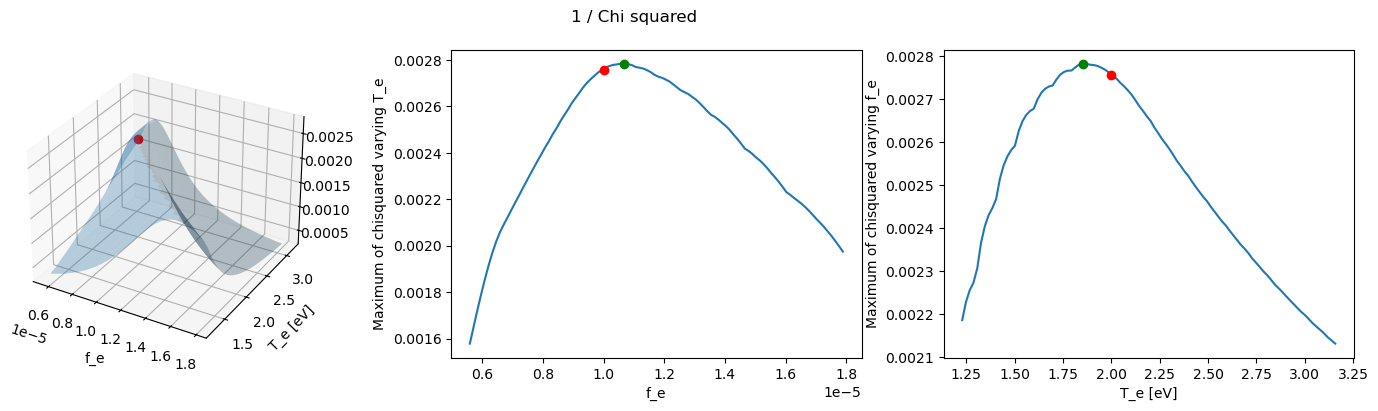

In [36]:
ax = plt.figure( figsize = ( 18, 4 ) ).add_subplot(1, 3, 1, projection='3d')
ax.plot_surface( *np.meshgrid(f_es,  T_es), 1 / chisquared.T, alpha=0.3 )

ax.plot( real_value['f_e'],  real_value['T_e'], 1 / real_value['chi2'], 'ro' )

plt.xlabel("f_e")
plt.ylabel("T_e [eV]")

plt.suptitle("1 / Chi squared")

splt.export( filename + "_1OverChisquared_3d" )

ax = plt.gcf().add_subplot( 1, 3, 2 )
plt.plot( f_es, 1 / chisquared_f_e )
plt.plot( real_value['f_e'], 1 / real_value['chi2'], 'ro' )
plt.plot( result['f_e'], 1 / result['chi2'], 'go' )

plt.xlabel("f_e")
plt.ylabel("Maximum of chisquared varying T_e")

ax = plt.gcf().add_subplot( 1, 3, 3 )
plt.plot( T_es, 1 / chisquared_T_e )
plt.plot( real_value['T_e'], 1 / real_value['chi2'], 'ro' )
plt.plot( result['T_e'], 1 / result['chi2'], 'go' )

plt.xlabel("T_e [eV]")
plt.ylabel("Maximum of chisquared varying f_e")
